# Gesture Recognition
  - Balakrishna Kommanaboina

In this project, you are going to see a 3D Conv model that will be able to predict the 5 gestures correctly. 

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# !unzip "/content/drive/MyDrive/Gesture Recognition/Project_data.zip" -d /content/

Streaming output truncated to the last 5000 lines.
 extracting: /content/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: /content/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: /content/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: /content/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: /content/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: /content/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: /content/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: /content/Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: /content/Project_data/train/WIN_20180926_17_35_12_Pro_

In [1]:
import numpy as np
import os
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install scipy==1.2
from scipy.misc import imread, imresize

  Using cached scipy-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (26.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


We set the random seed so that the results don't vary drastically.

In [3]:
!pip install keras

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

import cv2
import matplotlib.pyplot as plt
# % matplotlib inline

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('./datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./datasets/Project_data/val.csv').readlines())
train_path = './datasets/Project_data/train'
val_path = './datasets/Project_data/val'

In [7]:
!nvidia-smi

Mon Aug  2 11:45:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:40:00.0 Off |                  Off |
| 33%   28C    P8    23W / 230W |    236MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `input_height`,`input_width` and normalization such that you get high accuracy.

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [input_frames for input_frames in range(0, input_frames)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, input_frames, input_height, input_width, channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(input_height, input_width, channels))

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size, input_frames, input_height, input_width, channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(input_height, input_width, channels))

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


After writing the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
def train(batch_size, num_epochs, model, train_generator, val_generator, optimiser=None):
    curr_dt_time = datetime.datetime.now()

    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print('# batch size =', batch_size)    
    print('# epochs =', num_epochs)

    #write your optimizer
    if optimiser == None:
        optimiser = Adam() # default learning rate = 0.001
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
            
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, cooldown=1, verbose=1)
    
    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=20,verbose=1)
    callbacks_list = [checkpoint, LR, earlystop]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                callbacks=callbacks_list, validation_data=val_generator, 
                                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history

## Plotting:
Helper function to plot the training/validation accuracies/losses.


In [10]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    
    # summarize history for loss
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    # summarize history for accuracy
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model 1 : Experiment 1
- Initializing the model with Conv 3D neural network.

In [32]:
input_frames = 20
input_height = 120
input_width = 120

classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channels = 3


model_1 = Sequential()

model_1.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(input_frames, input_height, input_width, channels), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_1.add(Flatten())
model_1.add(Dense(1000, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(500, activation='relu'))
model_1.add(Dropout(0.5))

#softmax layer
model_1.add(Dense(classes, activation='softmax'))

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [33]:
batch_size = 30
num_epochs = 20

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
history_1 = train(batch_size, num_epochs, model_1, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 30
# epochs = 20
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_16 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_16 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_17 (Batc (None, 10, 60, 60, 16)    64        
________________________________

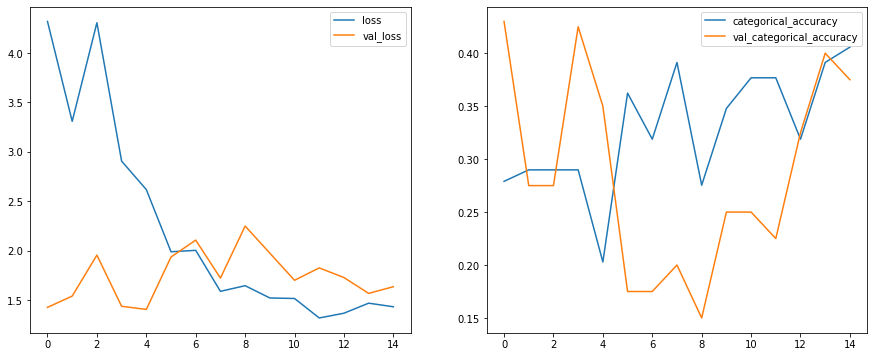

In [36]:
plot(history_1)

## Model 1 : Experiment 2
- Changing batch size to 40 to increase accuracy.
- Also changing learning rate in optimizer to 0.002 in order to run all the epochs.

In [37]:
batch_size = 40
num_epochs = 20

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
history_2 = train(batch_size, num_epochs, model_1, train_generator, val_generator, optimiser=Adam(0.002))

# training sequences = 663
# validation sequences = 100
# batch size = 40
# epochs = 20
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_16 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_16 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_17 (Batc (None, 10, 60, 60, 16)    64        
________________________________

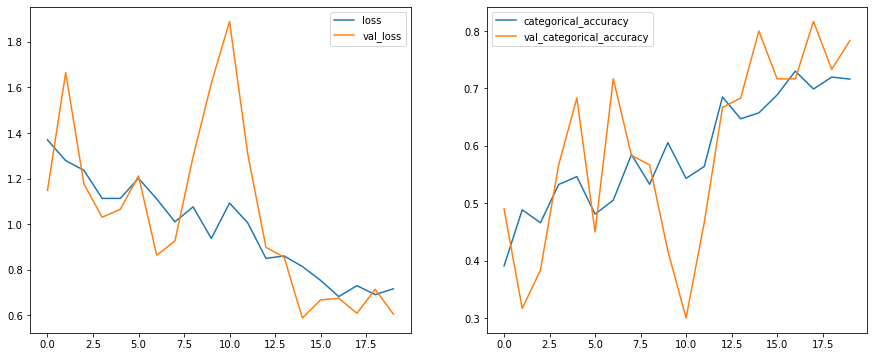

In [38]:
plot(history_2)

## Model 1 : Experiment 3
- Changing batch size to 20.

In [39]:
batch_size = 20
num_epochs = 20

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
history_3 = train(batch_size, num_epochs, model_1, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 20
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_16 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_16 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_17 (Batc (None, 10, 60, 60, 16)    64        
________________________________

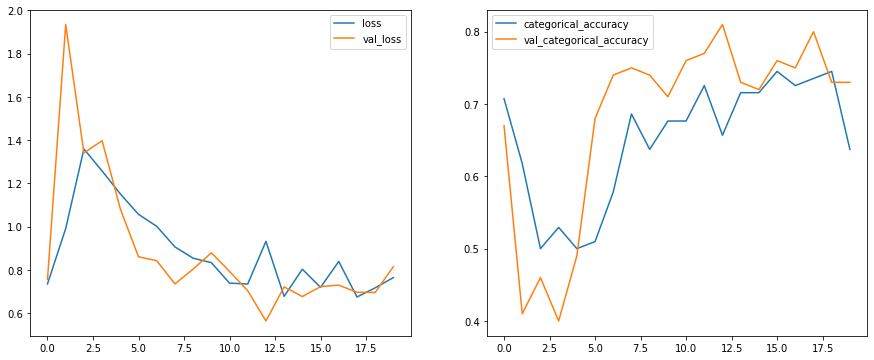

In [40]:
plot(history_3)

## Model 2: Experiment 1
- Changing the input frames to 16.
- Increasing the network filters to [16, 32, 64, 128]
- Keeping the constant kernel size to (3,3,3)
- Decreasing the dense neurons to 256.
- Changing batch-size back to 30.

In [47]:
input_frames = 16
input_height = 120
input_width = 120

classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channels = 3


model_2 = Sequential()

model_2.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(input_frames, input_height, input_width, channels), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))

model_2.add(Dense(256, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))

#softmax layer
model_2.add(Dense(classes, activation='softmax'))

In [48]:
batch_size = 30
num_epochs = 20

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
history_4 = train(batch_size, num_epochs, model_2, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 30
# epochs = 20
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_32 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_34 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation_32 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_35 (Batc (None, 8, 60, 60, 32)     128       
________________________________

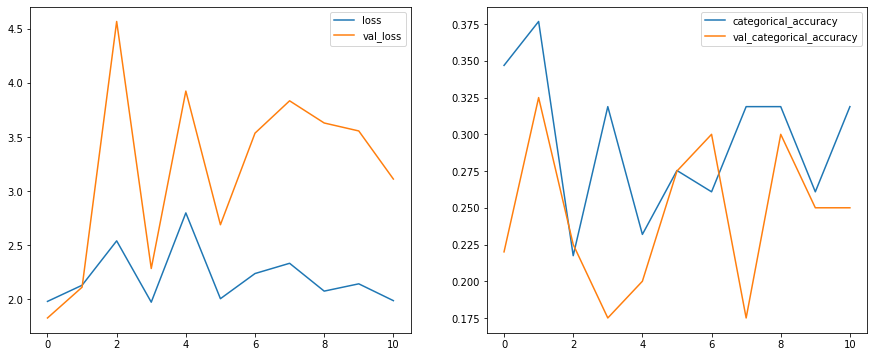

In [49]:
plot(history_4)

## Model 2: Experiment 2
- Changing learning rate 0.002 to optimiser to run all epochs.

In [50]:
batch_size = 30
num_epochs = 20

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
history_5 = train(batch_size, num_epochs, model_2, train_generator, val_generator, optimiser=Adam(0.002))

# training sequences = 663
# validation sequences = 100
# batch size = 30
# epochs = 20
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_32 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_34 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation_32 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_35 (Batc (None, 8, 60, 60, 32)     128       
________________________________

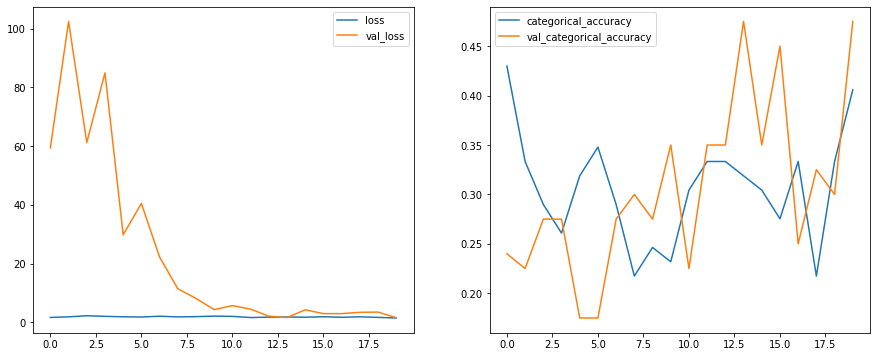

In [51]:
plot(history_5)

## Augmented Generator

In [12]:
def generator_aug(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [input_frames for input_frames in range(0, input_frames)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, input_frames, input_height, input_width, channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_aug = np.zeros((batch_size, input_frames, input_height, input_width, channels))

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(input_height, input_width, channels))

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(input_height, input_width,3))
                    
#                     M = cv2.getRotationMatrix2D((input_width//2, input_height//2),
#                                                 np.random.randint(-10,10), 1.0)
#                     rotated = cv2.warpAffine(image_resized, M, (input_width, input_height))

                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size, input_frames, input_height, input_width, channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_aug = np.zeros((batch_size, input_frames, input_height, input_width, channels))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image_resized=imresize(image,(input_height, input_width,3))
            
                    #normalizing the images
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(input_height,input_width,3))
                    
#                     M = cv2.getRotationMatrix2D((input_width//2,input_height//2),
#                                                 np.random.randint(-10,10), 1.0)
#                     rotated = cv2.warpAffine(image_resized, M, (input_width, input_height))

                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            yield batch_data, batch_labels

## Model 3: Experiment 1

In [17]:
input_frames = 16
input_height = 120
input_width = 120

classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channels = 3


model_3 = Sequential()

model_3.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(input_frames, input_height, input_width, channels), padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))

model_3.add(Dense(256, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))

#softmax layer
model_3.add(Dense(classes, activation='softmax'))

In [18]:
batch_size = 20
num_epochs = 20

train_generator = generator_aug(train_path, train_doc, batch_size)
val_generator = generator_aug(val_path, val_doc, batch_size)
history_6 = train(batch_size, num_epochs, model_3, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 20
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation_4 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 60, 60, 32)     128       
________________________________

ResourceExhaustedError:  OOM when allocating tensor with shape[420,16,16,14400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_1/batch_normalization_4/FusedBatchNormV3 (defined at <ipython-input-14-a9ce55d20778>:42) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_2701]

Function call stack:
train_function


In [14]:
# Check for the memory consumption
from sys import getsizeof
print("Memory util is {} Gigs". format(getsizeof(np.zeros((420,16,16,14400)))/(1024*1024*1024)))

Memory util is 11.53564466536045 Gigs


**Note:**
1. From the results we can see that the input shape is exceeding RAM capacity drastically (~11 GB).
2. The input shape of [420,16,16,14400] represents that the number of batches or batch_size was doubled somewhere in the code, so need to inspect the location and remove it.

## Model 4: Experiment 1
- Changing the hyperparameters to avoid the OOM error.
- Making changes to augmented generator to avoid doubling of batches.

In [11]:
def generator_augment(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [input_frames for input_frames in range(0, input_frames)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, input_frames, input_height, input_width, channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_aug = np.zeros((batch_size, input_frames, input_height, input_width, channels))

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(input_height, input_width,3))
                    
                    M = cv2.getRotationMatrix2D((input_width//2, input_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (input_width, input_height))

                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
#                 batch_data=np.concatenate([batch_data,batch_data_aug])
#                 batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data_aug, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size, input_frames, input_height, input_width, channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_aug = np.zeros((batch_size, input_frames, input_height, input_width, channels))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(input_height,input_width,3))
                    
                    M = cv2.getRotationMatrix2D((input_width//2,input_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (input_width, input_height))

                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
#                 batch_data=np.concatenate([batch_data,batch_data_aug])
#                 batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data_aug, batch_labels

In [24]:
input_frames = 16
input_height = 120
input_width = 120

classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channels = 3

kernel_size = (2,2,2)

model_4 = Sequential()

model_4.add(Conv3D(16, kernel_size, input_shape=(input_frames, input_height, input_width, channels), padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling3D(pool_size=(2,2,2)))

model_4.add(Conv3D(32, kernel_size, padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling3D(pool_size=(2,2,2)))

model_4.add(Conv3D(64, kernel_size, padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling3D(pool_size=(2,2,2)))

model_4.add(Conv3D(128, kernel_size, padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_4.add(Flatten())
model_4.add(Dense(128, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))

model_4.add(Dense(128, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))

#softmax layer
model_4.add(Dense(classes, activation='softmax'))

In [13]:
batch_size = 20
num_epochs = 20

train_generator = generator_augment(train_path, train_doc, batch_size)
val_generator = generator_augment(val_path, val_doc, batch_size)
history_7 = train(batch_size, num_epochs, model_4, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 20
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  400       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 60, 60, 32)     128       
__________________________________

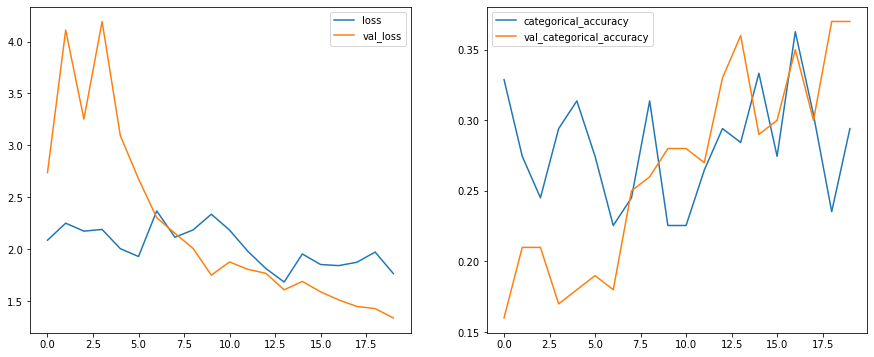

In [15]:
plot(history_7)

## Model 4: Experiment 2
- Increased the batch size to 40.
- Increase no.of epochs to 25.

In [16]:
batch_size = 40
num_epochs = 25

train_generator = generator_augment(train_path, train_doc, batch_size)
val_generator = generator_augment(val_path, val_doc, batch_size)
history_8 = train(batch_size, num_epochs, model_4, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 40
# epochs = 25
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  400       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 60, 60, 32)     128       
__________________________________

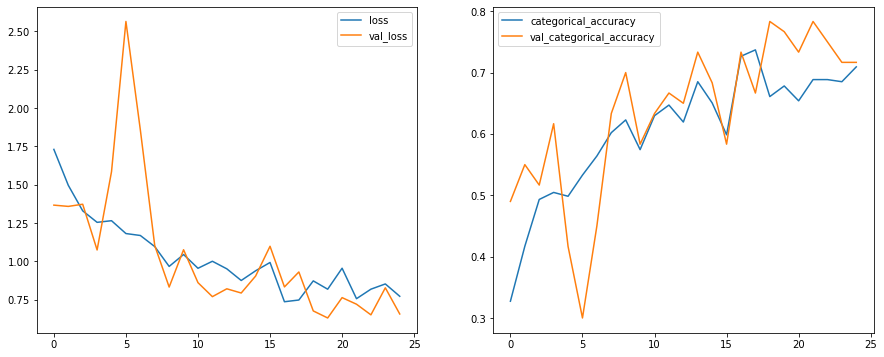

In [17]:
plot(history_8)

## Model 4: Experiment 3
- Changing the batch size to 30 to contrast with results.

In [18]:
batch_size = 30
num_epochs = 25

train_generator = generator_augment(train_path, train_doc, batch_size)
val_generator = generator_augment(val_path, val_doc, batch_size)
history_9 = train(batch_size, num_epochs, model_4, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 30
# epochs = 25
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  400       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 60, 60, 32)     128       
__________________________________

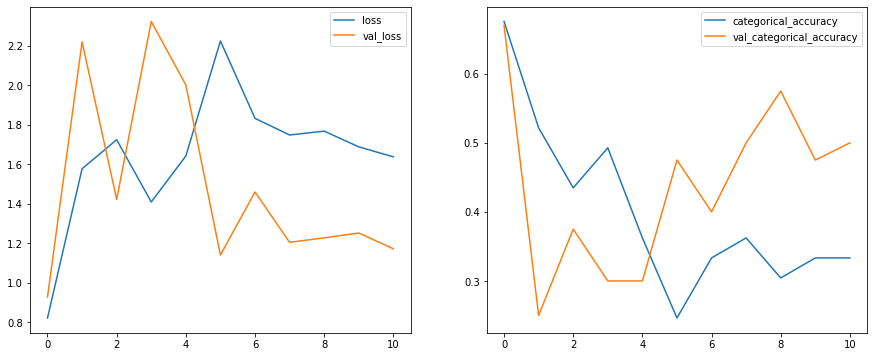

In [19]:
plot(history_9)

## Model 4 Experiment 4
- Changing to Regular generator

In [25]:
batch_size = 40
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
history_18 = train(batch_size, num_epochs, model_4, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 40
# epochs = 25
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  400       
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 60, 60, 32)     128       
________________________________

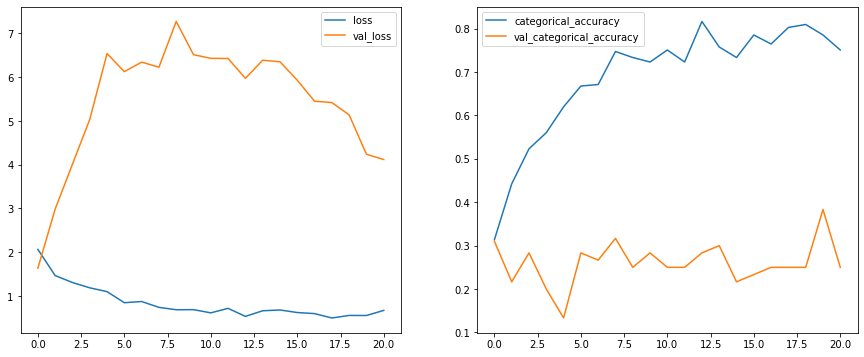

In [26]:
plot(history_18)

## Model 5: Experiment 1
- Changed the kernel size back to (3,3,3).
- Decreased the dense neurons to 64.
- Decreased the dropout to 0.25.

In [22]:
input_frames = 16
input_height = 120
input_width = 120

classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channels = 3

kernel_size = (3,3,3)

model_5 = Sequential()

model_5.add(Conv3D(16, kernel_size, input_shape=(input_frames, input_height, input_width, channels), padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling3D(pool_size=(2,2,2)))

model_5.add(Conv3D(32, kernel_size, padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling3D(pool_size=(2,2,2)))

model_5.add(Conv3D(64, kernel_size, padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling3D(pool_size=(2,2,2)))

model_5.add(Conv3D(128, kernel_size, padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.25))

model_5.add(Dense(64, activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.25))

#softmax layer
model_5.add(Dense(classes, activation='softmax'))

In [23]:
batch_size = 30
num_epochs = 25

train_generator = generator_augment(train_path, train_doc, batch_size)
val_generator = generator_augment(val_path, val_doc, batch_size)
history_10 = train(batch_size, num_epochs, model_5, train_generator, val_generator, optimiser=optimizers.Adam(lr=0.002))

# training sequences = 663
# validation sequences = 100
# batch size = 30
# epochs = 25
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 60, 60, 32)     128       
________________________________

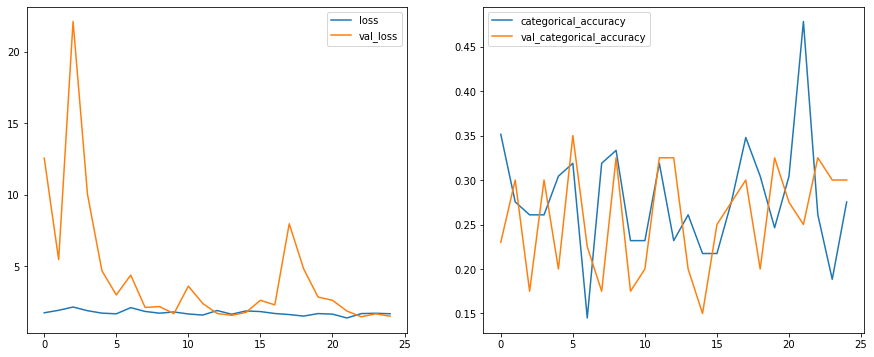

In [24]:
plot(history_10)

## Model 5: Experiment2
- Changing batch size to 20.

In [25]:
batch_size = 20
num_epochs = 25

train_generator = generator_augment(train_path, train_doc, batch_size)
val_generator = generator_augment(val_path, val_doc, batch_size)
history_11 = train(batch_size, num_epochs, model_5, train_generator, val_generator, optimiser=optimizers.Adam(lr=0.002))

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 25
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 60, 60, 32)     128       
________________________________

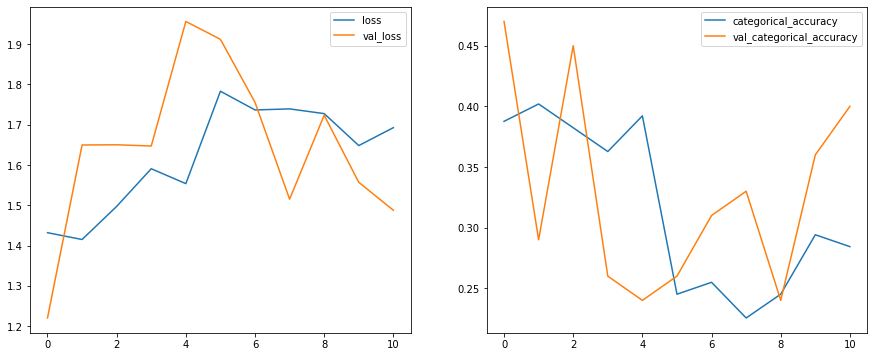

In [27]:
plot(history_11)

## Model 6: Experiment 1
- Image size was changed to 100*100.
- kernel size reduced to (2,2,2).
- Dropout increased back to 0.5.

In [30]:
input_frames = 16
input_height = 100
input_width = 100

classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channels = 3

kernel_size = (2,2,2)

model_6 = Sequential()

model_6.add(Conv3D(16, kernel_size, input_shape=(input_frames, input_height, input_width, channels), padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling3D(pool_size=(2,2,2)))

model_6.add(Conv3D(32, kernel_size, padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling3D(pool_size=(2,2,2)))

model_6.add(Conv3D(64, kernel_size, padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling3D(pool_size=(2,2,2)))

model_6.add(Conv3D(128, kernel_size, padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_6.add(Flatten())
model_6.add(Dense(64, activation='relu'))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.5))

model_6.add(Dense(64, activation='relu'))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.5))

#softmax layer
model_6.add(Dense(classes, activation='softmax'))

In [32]:
batch_size = 40
num_epochs = 25

train_generator = generator_augment(train_path, train_doc, batch_size)
val_generator = generator_augment(val_path, val_doc, batch_size)
history_12 = train(batch_size, num_epochs, model_6, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 40
# epochs = 25
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 16, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_30 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
activation_20 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
batch_normalization_31 (Batc (None, 8, 50, 50, 32)     128       
________________________________

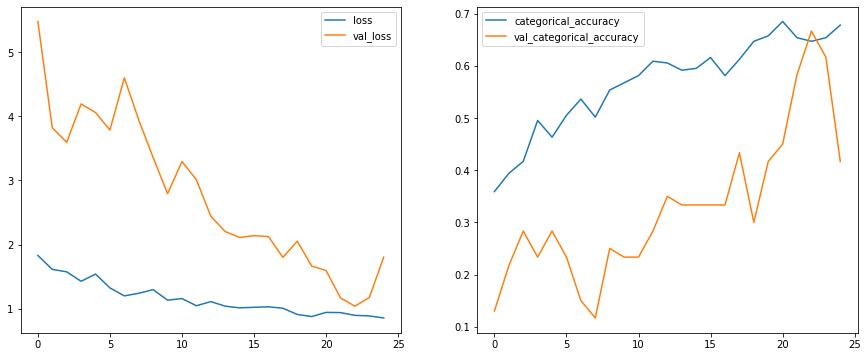

In [33]:
plot(history_12)

## Model 7: Experiment 1
- Image size was changed back to 120*120.
- Increased no.of dense neurons to 256.

In [41]:
input_frames = 16
input_height = 120
input_width = 120

classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channels = 3

kernel_size = (3,3,3)

model_7 = Sequential()

model_7.add(Conv3D(16, kernel_size, input_shape=(input_frames, input_height, input_width, channels), padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling3D(pool_size=(2,2,2)))

model_7.add(Conv3D(32, kernel_size, padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling3D(pool_size=(2,2,2)))

model_7.add(Conv3D(64, kernel_size, padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling3D(pool_size=(2,2,2)))

model_7.add(Conv3D(128, kernel_size, padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_7.add(Flatten())
model_7.add(Dense(256, activation='relu'))
model_7.add(BatchNormalization())
model_7.add(Dropout(0.5))

model_7.add(Dense(256, activation='relu'))
model_7.add(BatchNormalization())
model_7.add(Dropout(0.5))

#softmax layer
model_7.add(Dense(classes, activation='softmax'))

In [42]:
batch_size = 30
num_epochs = 25

train_generator = generator_augment(train_path, train_doc, batch_size)
val_generator = generator_augment(val_path, val_doc, batch_size)
history_13 = train(batch_size, num_epochs, model_7, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 30
# epochs = 25
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_40 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_60 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation_40 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_61 (Batc (None, 8, 60, 60, 32)     128       
_______________________________

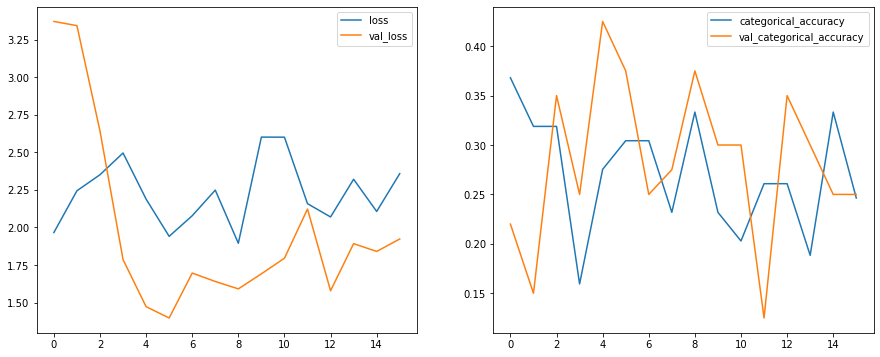

In [43]:
plot(history_13)

## Model 8: Experiment 1
- 2D CNN with LSTM

In [13]:
input_frames = 16
input_height = 120
input_width = 120

classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channels = 3

model_8 = Sequential()

model_8.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(input_frames, input_height, input_width, channels)))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_8.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_8.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_8.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_8.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model_8.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
# model_8.add(TimeDistributed(BatchNormalization()))
# model_8.add(TimeDistributed(MaxPooling2D((2, 2))))

model_8.add(TimeDistributed(Flatten()))


model_8.add(LSTM(128))
model_8.add(Dropout(0.5))
        
model_8.add(Dense(128,activation='relu'))
model_8.add(Dropout(0.5))
        
model_8.add(Dense(classes, activation='softmax'))

In [14]:
batch_size = 30
num_epochs = 25

train_generator = generator_augment(train_path, train_doc, batch_size)
val_generator = generator_augment(val_path, val_doc, batch_size)
history_14 = train(batch_size, num_epochs, model_8, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 30
# epochs = 25
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 16, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 30, 30, 32)    0         
________________________________

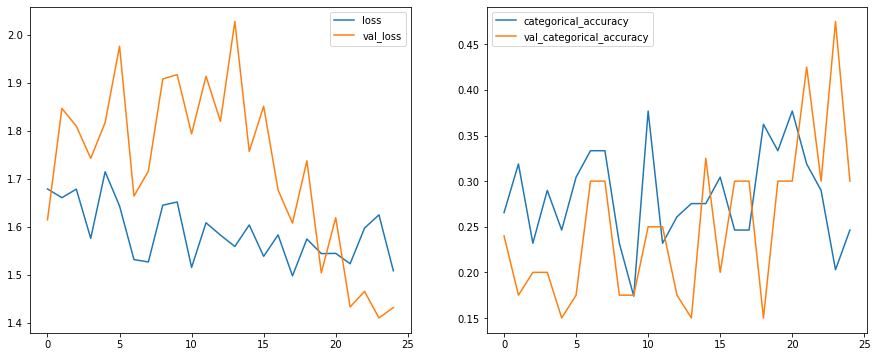

In [15]:
plot(history_14)

## Model 8: Experiment 2
- Changing batch-size
- Changing to normal generator with no augmentation

In [16]:
batch_size = 40
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
history_15 = train(batch_size, num_epochs, model_8, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 40
# epochs = 25
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 16, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 30, 30, 32)    0         
________________________________

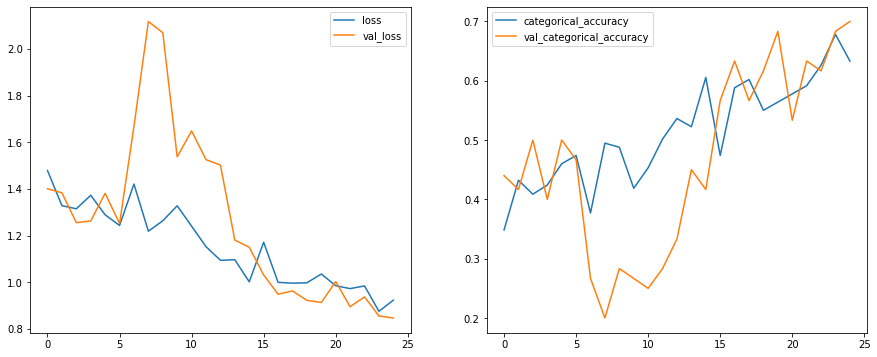

In [17]:
plot(history_15)

## Model 9: Experiment 1
- 2D CNN with GRU

In [18]:
input_frames = 16
input_height = 120
input_width = 120

classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channels = 3

model_9 = Sequential()

model_9.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(input_frames, input_height, input_width, channels)))
model_9.add(TimeDistributed(BatchNormalization()))
model_9.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_9.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_9.add(TimeDistributed(BatchNormalization()))
model_9.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_9.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_9.add(TimeDistributed(BatchNormalization()))
model_9.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_9.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_9.add(TimeDistributed(BatchNormalization()))
model_9.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_9.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_9.add(TimeDistributed(BatchNormalization()))
model_9.add(TimeDistributed(MaxPooling2D((2, 2))))

model_9.add(TimeDistributed(Flatten()))


model_9.add(GRU(128))
model_9.add(Dropout(0.5))
        
model_9.add(Dense(128,activation='relu'))
model_9.add(Dropout(0.5))
        
model_9.add(Dense(classes, activation='softmax'))

In [19]:
batch_size = 40
num_epochs = 25

train_generator = generator_augment(train_path, train_doc, batch_size)
val_generator = generator_augment(val_path, val_doc, batch_size)
history_16 = train(batch_size, num_epochs, model_9, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 40
# epochs = 25
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 16, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 16, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 16, 30, 30, 32)    0         
________________________________

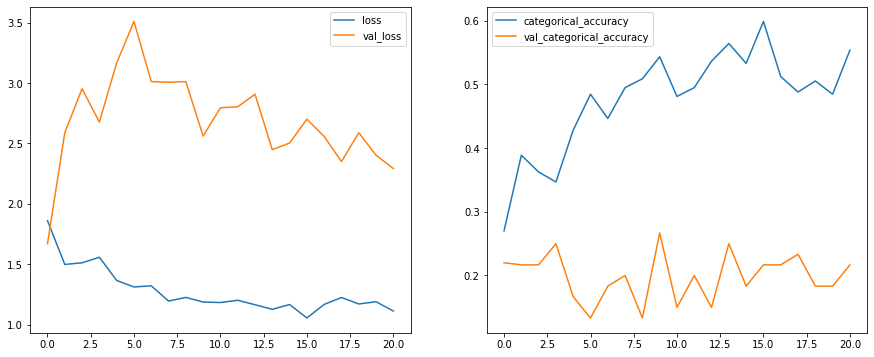

In [20]:
plot(history_16)

## Model 9: Experiment 2
- Changing to the regular generator with no augmentation.

In [21]:
batch_size = 40
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
history_17 = train(batch_size, num_epochs, model_9, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 40
# epochs = 25
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 16, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 16, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 16, 30, 30, 32)    0         
________________________________

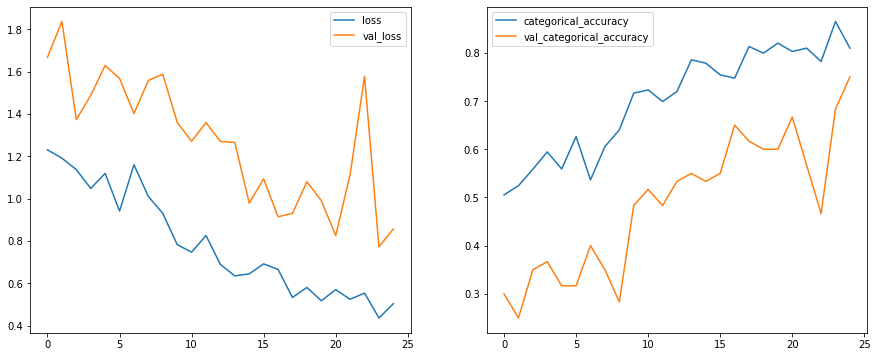

In [22]:
plot(history_17)